## Back Propogation for Activation Function and Multi-Layer Perceptron

This post illustrates the basic implementation of realizing Back Prop using Numpy for study purpose.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

A layer in neural network
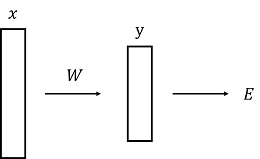

In [2]:
# base class for neural network layers
class Layer():
    def __init__(self):
        pass
    
    # forward pass
    # compute output value y given input x
    def forward(self, x):
        raise NotImplementedError
    
    # backward pass
    # compute gradient for weight variables dE/dW
    # and compute gradient for input dE/dx
    # given 'node_grad' which is the gradient passed from previous layers dE/dy
    def backward(self, node_grad):
        raise NotImplementedError
    
    # update weight variables based on gradients
    def update(self, learning_rate):
        raise NotImplementedError

### Sigmoid Function

$$y = \frac{1}{1+e^{-x}}$$

- Gradients 

$$\frac{\partial{y}}{\partial{x}}=y*(1-y)$$

- Backpropogation

$$\frac{\partial{E}}{\partial{x}}=\frac{\partial{E}}{\partial{y}}*y*(1-y)$$

In [3]:
class Sigmoid(Layer):    
    def forward(self, x): # only for data sample, different if using batches
        self.y = 1 / (1 + np.exp(-x))
        return self.y
    
    def backward(self, node_grad):
        return node_grad * (self.y * (1-self.y))
    
    # no parameters to train
    def update(self, learning_rate):
        pass

### Relu Function

$$
y= 
\begin{cases}
    x, & \text{if } x\gt 0\\
    0, & \text{otherwise}
\end{cases}
$$

- Gradients 

$$
\frac{\partial{y}}{\partial{x}}= 
\begin{cases}
    1, & \text{if } x\gt 0\\
    0, & \text{otherwise}
\end{cases}
$$

- Backpropogation

$$
\frac{\partial{E}}{\partial{x}}= 
\begin{cases}
    \frac{\partial{E}}{\partial{y}}, & \text{if } x\gt 0\\
    0, & \text{otherwise}
\end{cases}
$$

In [4]:
class Relu():        
    def forward(self, x):
        self.x = x
        return np.maximum(x, 0)
    
    def backward(self, node_grad):
        return node_grad * (self.x > 0)
    
    def update(self, learning_rate):
        pass

### Softmax + CrossEntropy

For forward and backward computation, please check https://deepnotes.io/softmax-crossentropy

Cross Entropy Loss with Softmax function are used as the output layer extensively. So here, I will use the derivative of softmax to easiy derive the derivative of the cross entropy loss function as the post suggests.

In [5]:
class Softmax_Cross_Entropy():    

    """
    usually, the function code for forward pass is like this:
    def softmax(X):
    exps = np.exp(X)
    return exps / np.sum(exps)
    
    because the numerical range of floating point numbers in numpy is limited,
    for float64 is 10^308, exp with too large x will yield inf
    so need to normalize value to avoid overflow
    """
    
    def forward(self, x):
        exps = np.exp(x - np.max(x)) # to stabilize softmax function
        self.y = exps / np.sum(exps)
        return self.y
    
    # backward pass
    # compute gradient of softmax+crossentropy simultaneously
    def backward(self, label):
        self.out_grad = self.y - label   # which is a very simple and elegant expression
        return self.out_grad
    
    def update(self, learning_rate):
        pass

### Linear Layer

For forward and backward computation for dense layer, please check http://cs231n.stanford.edu/handouts/linear-backprop.pdf

In [6]:
class Linear(Layer):
    def __init__(self, size_in, size_out, with_bias): # params
        self.size_in = size_in 
        self.size_out = size_out
        self.with_bias = with_bias
        self.W = self.initialize_weight() 
        if with_bias:
            self.b = np.zeros(size_out)
    
    # weight initialization
    def initialize_weight(self):
        epsilon = np.sqrt(2.0 / (self.size_in + self.size_out))
        return epsilon * (np.random.rand(self.size_in, self.size_out) * 2 - 1) 
        
    def forward(self, x):
        self.x = x
        self.y = x @ self.W + self.b  # @ is shortcut for matrix multiplication
        return self.y
    
    def backward(self, node_grad):
        self.G_W = np.outer(self.x, node_grad)  # derivative for weight matrix
        if self.with_bias: # derivative for bias
            self.G_b = node_grad
        return node_grad @ self.W.T
    
    # update weight params, perform gradient descent
    def update(self, learning_rate):
        self.W -= learning_rate * self.G_W
        if self.with_bias:
            self.b -= learning_rate * self.G_b

In [7]:
class MLP():
    
    def __init__(self, layer_size, with_bias=True, activation="sigmoid", learning_rate=1):
        assert len(layer_size) >= 2  # at least input+output
        self.layer_size = layer_size
        self.with_bias = with_bias
        if activation == "sigmoid":
            self.activation = Sigmoid
        elif activation == "relu":
            self.activation = Relu
        else:
            raise Exception("activation not implemented")
        self.learning_rate = learning_rate
        self.build_model() # help function to build model
        
    def build_model(self):
        self.layers = [] # initializing layer list
        
        size_in = self.layer_size[0] # for first input layer
        
        for hidden_unit in self.layer_size[1:-1]: # loop thru 2nd layer to the last but 2 layer
            self.layers.append(Linear(size_in, hidden_unit, self.with_bias))
            self.layers.append(self.activation())
            size_in = hidden_unit
            
        # for final output layer, use softmax + cross entropy
        self.layers.append(Linear(size_in, self.layer_size[-1], self.with_bias))
        self.layers.append(Softmax_Cross_Entropy())
       
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, label):
        node_grad = label
        for layer in reversed(self.layers): # backprop thru layers
            node_grad = layer.backward(node_grad)
            
    def update(self, learning_rate):
        for layer in self.layers:
            layer.update(learning_rate)
            
    def train(self, x, label):
        y = self.forward(x)
        self.backward(label)
        self.update(self.learning_rate)
    
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return np.argmax(x)
    
    def loss(self, x, label):
        y = self.forward(x)
        return -np.log(y) @ label # cross entropy loss

#### Create a simple dataset (XOR) to test our function
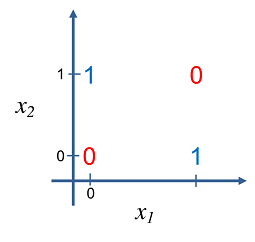

In [8]:
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])
Y = np.array([
    [0, 1],
    [1, 0],
    [1, 0],
    [0, 1]
])

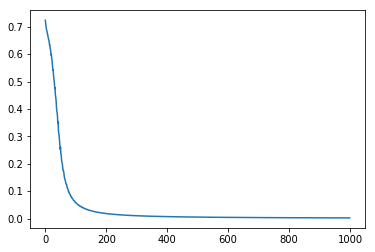

In [9]:
np.random.seed(208) 
epoch = 1000 
N = X.shape[0] # get number of training data

# craete a MLP with layer size [2,4,2] and learning_rate 0.1
mlp = MLP([2, 4, 2], learning_rate=.1, activation="relu")

loss = np.zeros(epoch) # store losses

for ep in range(epoch):
    # train on each training data
    for i in range(N):
        mlp.train(X[i], Y[i])
        
    # compute loss
    for i in range(N):
        loss[ep] += mlp.loss(X[i], Y[i])
        
    loss[ep] /= N
    
# plot loss curve
plt.figure()
ix = np.arange(epoch)
plt.plot(ix, loss)

## Using built-in Keras module

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(8, input_dim=2, activation="relu"))
model.add(Dense(2, activation="softmax"))

sgd = SGD(lr=.1)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X, Y, epochs=200)

W0305 12:05:52.668808 4512511424 deprecation.py:506] From /Users/junxxx/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


The speed of Keras is much faster than the implementation in Numpy with an unbeatable performance, so in real life we tend to use built-in librares/modules to build and train our neural network models!